## User Engagement Analysis

### Major Objectives 
Track the user’s engagement using the following engagement metrics: 
- sessions frequency 
- the duration of the session 
- the sessions total traffic (download and upload (bytes))

### Sub Tasks
- Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric 
- Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement. 
- Compute the minimum, maximum, average & total non- normalized metrics for each cluster. 
- Interpret your results visually with accompanying text explaining your findings.
- Aggregate user total traffic per application and derive the top 10 most engaged users per application
- Plot the top 3 most used applications using appropriate charts.  
- Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics: 
- What is the optimized value of k (use elbow method for this)?  
- Interpret your findings. 


### Importing Liberaries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from plotly.subplots import make_subplots
from scipy.stats import zscore
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist

import matplotlib
import warnings
import plotly.io as pio
warnings.filterwarnings("ignore", category=FutureWarning)
import math
from IPython.display import Image
import sys, os

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts..')))
from data_visualizer import *
from data_selector import *
from outlier_handler import*
from df_outlier import DfOutlier





### Load Data

In [4]:
clean_df = pd.read_csv("../data/my_clean_data.csv")
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146887 entries, 0 to 146886
Data columns (total 55 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Unnamed: 0                        146887 non-null  int64  
 1   Bearer Id                         146887 non-null  int64  
 2   Start                             146887 non-null  object 
 3   Start ms                          146887 non-null  float64
 4   End                               146887 non-null  object 
 5   End ms                            146887 non-null  float64
 6   IMSI                              146887 non-null  int64  
 7   MSISDN/Number                     146887 non-null  int64  
 8   IMEI                              146887 non-null  int64  
 9   Last Location Name                146887 non-null  object 
 10  Avg RTT DL (ms)                   146887 non-null  float64
 11  Avg RTT UL (ms)                   146887 non-null  f

### User Engagement Analysis

**1. Top 10 customers per engagement metric**

In [5]:
total_users = clean_df['MSISDN/Number'].nunique()
print("The total number of Customer in the TellCo are = ",total_users)

The total number of Customer in the TellCo are =  105716


In [6]:
engagement_of_users = clean_df[['MSISDN/Number', 'Bearer Id', 'Dur. (ms).1', 'Total Data Volume (Bytes)']].copy().rename(columns={'Dur. (ms).1': 'time_duration'})#, 'total_data': 'total_data_volume'})
engagement_of_users

MSISDN/Number            Bearer Id  time_duration  \
0         33664962239 -9223372036854775808    245108160.5   
1         33681854413 -9223372036854775808    245108160.5   
2         33760627129 -9223372036854775808    245108160.5   
3         33750343200 -9223372036854775808    245108160.5   
4         33699795932 -9223372036854775808    245108160.5   
...               ...                  ...            ...   
146882    33762146363  7349883264234529792     61661729.0   
146883    33761274518 -9223372036854775808     84940610.0   
146884    33626114091 -9223372036854775808    125622433.0   
146885    33645655643 -9223372036854775808    113545185.0   
146886    33668648496 -9223372036854775808     59587792.0   

        Total Data Volume (Bytes)  
0                     345629377.0  
1                     707185356.0  
2                     307690973.0  
3                     889352748.0  
4                     607681403.0  
...                           ...  
146882                352656000.0  
146883                116264912.0  
146884                666947481.0  
146885                922173944.0  
146886                872761860.0  

[146887 rows x 4 columns]

In [7]:
user_engagements = engagement_of_users.groupby(
    'MSISDN/Number').agg({'Bearer Id': 'count', 'time_duration': 'sum', 'Total Data Volume (Bytes)': 'sum'})
user_engagements = user_engagements.rename(
    columns={'Bearer Id': 'user_sessions'})
user_engagements.head(5)

user_sessions  time_duration  Total Data Volume (Bytes)
MSISDN/Number                                                         
33601001722                1    116720140.0               8.786906e+08
33601001754                1    181230963.0               1.568596e+08
33601002511                1    134969374.0               5.959665e+08
33601007832                1     49878024.0               4.223207e+08
33601008617                2     37104453.0               1.457411e+09

In [8]:
#top 10 user Engagements relative to time
user_engagements.nlargest(10, 'time_duration')

user_sessions  time_duration  Total Data Volume (Bytes)
MSISDN/Number                                                         
33625779332               17   4.138399e+09               8.499621e+09
33626320676               18   4.007350e+09               7.971167e+09
33614892860               17   3.900326e+09               8.846226e+09
33659725664               16   3.492572e+09               7.705863e+09
33760536639               15   3.396886e+09               8.514774e+09
33675877202               15   3.332226e+09               7.891111e+09
33667163239               13   3.114213e+09               5.618394e+09
33603127838               12   2.855537e+09               4.976195e+09
33627080969               12   2.782433e+09               5.754731e+09
33604515716               12   2.780126e+09               5.487855e+09

In [9]:
#top 10 user Engagements relative to time
user_engagements.nlargest(10, 'user_sessions')

user_sessions  time_duration  Total Data Volume (Bytes)
MSISDN/Number                                                         
33626320676               18   4.007350e+09               7.971167e+09
33614892860               17   3.900326e+09               8.846226e+09
33625779332               17   4.138399e+09               8.499621e+09
33659725664               16   3.492572e+09               7.705863e+09
33675877202               15   3.332226e+09               7.891111e+09
33760536639               15   3.396886e+09               8.514774e+09
33667163239               13   3.114213e+09               5.618394e+09
33603127838               12   2.855537e+09               4.976195e+09
33604515716               12   2.780126e+09               5.487855e+09
33627080969               12   2.782433e+09               5.754731e+09

In [10]:
#top 10 user Engagements relative to time
user_engagements.nlargest(10, 'Total Data Volume (Bytes)')

user_sessions  time_duration  Total Data Volume (Bytes)
MSISDN/Number                                                         
33614892860               17   3.900326e+09               8.846226e+09
33760536639               15   3.396886e+09               8.514774e+09
33625779332               17   4.138399e+09               8.499621e+09
33626320676               18   4.007350e+09               7.971167e+09
33675877202               15   3.332226e+09               7.891111e+09
33659725664               16   3.492572e+09               7.705863e+09
33666464084               11   2.597086e+09               7.308501e+09
33760413819               12   2.676862e+09               7.132371e+09
33664712899               11   2.603570e+09               6.872337e+09
33698792269               11   2.639395e+09               6.540899e+09

In [11]:
def mult_hist(sr, rows, cols, title_text, subplot_titles, interactive=False):
    fig = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles)
    for i in range(rows):
        for j in range(cols):
            x = ["-> " + str(i) for i in sr[i+j].index]
            fig.add_trace(go.Bar(x=x, y=sr[i+j].values), row=i+1, col=j+1)
    fig.update_layout(showlegend=False, title_text=title_text)
    if(interactive):
        fig.show()
    else:
        return Image(pio.to_image(fig, format='png', width=1200))


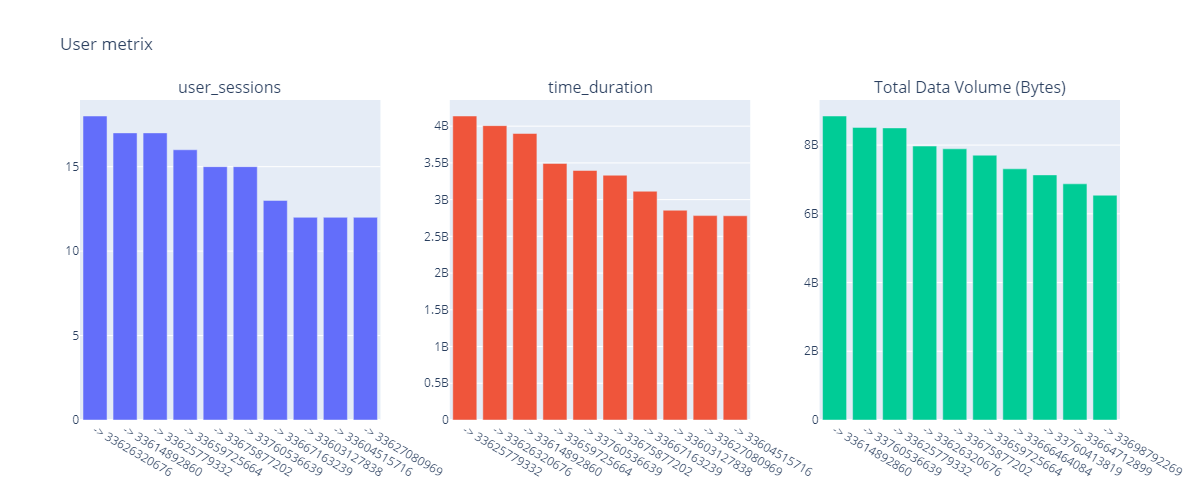

In [12]:
sessions = user_engagements.nlargest(10, "user_sessions")['user_sessions']
duration = user_engagements.nlargest(10, "time_duration")['time_duration']
total_data_volume = user_engagements.nlargest(10, "Total Data Volume (Bytes)")['Total Data Volume (Bytes)']

mult_hist([sessions, duration, total_data_volume], 1,3, "User metrix", ['user_sessions', 'time_duration','Total Data Volume (Bytes)'])

In [13]:
#Check for outliers

<AxesSubplot:>

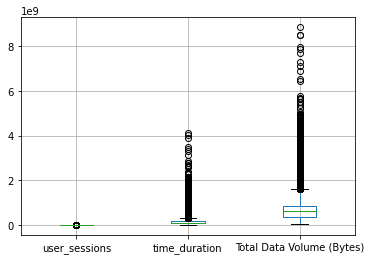

In [14]:
user_engagements.boxplot()

In [15]:
df_outliers = DfOutlier(user_engagements)
df_outliers.getOverview()

Q1       median           Q3  \
label                                                               
user_sessions              1.000000e+00          1.0          2.0   
time_duration              7.272720e+07  103112793.5  172800017.0   
Total Data Volume (Bytes)  3.579374e+08  616932960.5  856483490.5   

                                    IQR      skew  number_of_outliers  \
label                                                                   
user_sessions              1.000000e+00  3.317168                3144   
time_duration              1.000728e+08  5.489767                6880   
Total Data Volume (Bytes)  4.985461e+08  2.232846                5148   

                          percentage_of_outliers   min_value     max_value  \
label                                                                        
user_sessions                              2.97%         1.0  1.800000e+01   
time_duration                              6.51%   7142988.0  4.138399e+09   
Total Data Volume (Bytes)                  4.87%  33249009.0  8.846226e+09   

                                   mean  
label                                    
user_sessions              1.389449e+00  
time_duration              1.392080e+08  
Total Data Volume (Bytes)  6.888632e+08

- Outliers are presented in all metrics but they are not very skewed

In [16]:
df_outliers.replace_outliers_with_iqr(
    ['user_sessions', 'time_duration', 'Total Data Volume (Bytes)'])
df_outliers = DfOutlier(user_engagements)
df_outliers.getOverview()

Q1       median           Q3  \
label                                                               
user_sessions              1.000000e+00          1.0          2.0   
time_duration              7.272720e+07  103112793.5  172800017.0   
Total Data Volume (Bytes)  3.579374e+08  616932960.5  856483490.5   

                                    IQR      skew  number_of_outliers  \
label                                                                   
user_sessions              1.000000e+00  1.799445                   0   
time_duration              1.000728e+08  0.808236                   0   
Total Data Volume (Bytes)  4.985461e+08  0.762778                   0   

                          percentage_of_outliers   min_value     max_value  \
label                                                                        
user_sessions                               0.0%         1.0  3.500000e+00   
time_duration                               0.0%   7142988.0  3.229092e+08   
Total Data Volume (Bytes)                   0.0%  33249009.0  1.604303e+09   

                                   mean  
label                                    
user_sessions              1.356635e+00  
time_duration              1.290880e+08  
Total Data Volume (Bytes)  6.622816e+08

<AxesSubplot:>

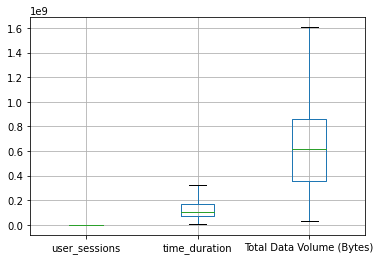

In [17]:
user_engagements.boxplot()

- Know outliers are properly hundeled next manage sclaings or normalization will be applied

2. Classification of customers in the three groups of engagement after Normalizing each engagement metric and run a k-means (k=3).

In [18]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(user_engagements)
pd.DataFrame(scaled_array).head(5)

0         1         2
0 -0.548662 -0.145783  0.548274
1 -0.548662  0.614622 -1.280491
2 -0.548662  0.069326 -0.168010
3 -0.548662 -0.933668 -0.607943
4  0.989780 -1.084233  2.014468

In [19]:
normalized_engagements = normalize(scaled_array)
pd.DataFrame(normalized_engagements).head(5)

0         1         2
0 -0.695185 -0.184715  0.694693
1 -0.360335  0.403654 -0.840965
2 -0.949272  0.119944 -0.290684
3 -0.441786 -0.751795 -0.489520
4  0.397079 -0.434972  0.808163

In [20]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(normalized_engagements)
kmeans.labels_

array([0, 2, 2, ..., 0, 2, 2])

In [21]:
user_engagements.insert(0, 'cluster', kmeans.labels_)
user_engagements.head(5)

cluster  user_sessions  time_duration  \
MSISDN/Number                                          
33601001722          0            1.0    116720140.0   
33601001754          2            1.0    181230963.0   
33601002511          2            1.0    134969374.0   
33601007832          0            1.0     49878024.0   
33601008617          1            2.0     37104453.0   

               Total Data Volume (Bytes)  
MSISDN/Number                             
33601001722                 8.786906e+08  
33601001754                 1.568596e+08  
33601002511                 5.959665e+08  
33601007832                 4.223207e+08  
33601008617                 1.457411e+09

In [22]:
user_engagements['cluster'].value_counts()

0    52815
1    28333
2    24568
Name: cluster, dtype: int64

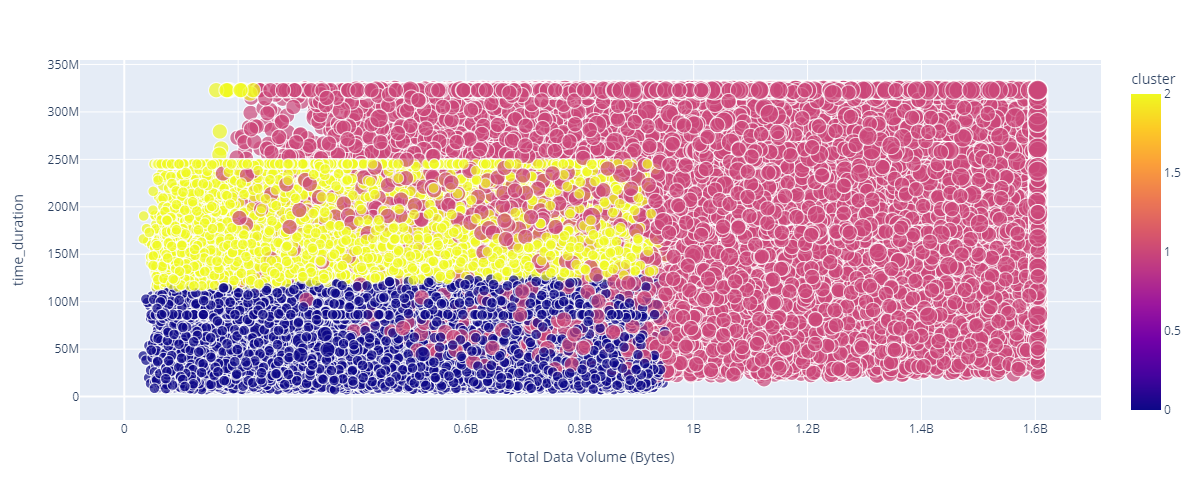

In [23]:
fig = px.scatter(user_engagements, x='Total Data Volume (Bytes)', y="time_duration",
                 color='cluster', size='user_sessions')
# fig.show()
Image(pio.to_image(fig, format='png', width=1200)) #'user_sessions', 'time_duration', 'Total Data Volume (Bytes)'

3. minimum, maximum, average & total non- normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings.

In [24]:
C1 = user_engagements[user_engagements["cluster"]==0]
C1.describe()

cluster  user_sessions  time_duration  Total Data Volume (Bytes)
count  52815.0   52815.000000   5.281500e+04               5.281500e+04
mean       0.0       1.006229   6.689713e+07               5.003581e+08
std        0.0       0.078680   3.137462e+07               2.431956e+08
min        0.0       1.000000   7.142988e+06               3.324901e+07
25%        0.0       1.000000   3.513357e+07               2.922548e+08
50%        0.0       1.000000   8.427857e+07               5.032206e+08
75%        0.0       1.000000   8.640089e+07               7.101586e+08
max        0.0       2.000000   1.253613e+08               9.495983e+08

In [25]:
C2 = user_engagements[user_engagements["cluster"]==1]
C2.describe()

cluster  user_sessions  time_duration  Total Data Volume (Bytes)
count  28333.0   28333.000000   2.833300e+04               2.833300e+04
mean       1.0       2.318568   2.078496e+08               1.114896e+09
std        0.0       0.548013   9.329470e+07               3.728183e+08
min        1.0       2.000000   1.823580e+07               1.197685e+08
25%        1.0       2.000000   1.314981e+08               8.341880e+08
50%        1.0       2.000000   2.002062e+08               1.115427e+09
75%        1.0       3.000000   3.180221e+08               1.466217e+09
max        1.0       3.500000   3.229092e+08               1.604303e+09

In [26]:
C3 = user_engagements[user_engagements["cluster"]==2]
C3.describe()

cluster  user_sessions  time_duration  Total Data Volume (Bytes)
count  24568.0   24568.000000   2.456800e+04               2.456800e+04
mean       2.0       1.000570   1.719508e+08               4.883990e+08
std        0.0       0.023865   3.887184e+07               2.451628e+08
min        2.0       1.000000   1.145791e+08               3.357584e+07
25%        2.0       1.000000   1.409629e+08               2.762876e+08
50%        2.0       1.000000   1.624370e+08               4.847971e+08
75%        2.0       1.000000   1.909341e+08               7.006238e+08
max        2.0       2.000000   3.229092e+08               9.507607e+08

4. Aggregate user total traffic per application and derive the top 10 most engaged users per application

In [27]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146887 entries, 0 to 146886
Data columns (total 55 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Unnamed: 0                        146887 non-null  int64  
 1   Bearer Id                         146887 non-null  int64  
 2   Start                             146887 non-null  object 
 3   Start ms                          146887 non-null  float64
 4   End                               146887 non-null  object 
 5   End ms                            146887 non-null  float64
 6   IMSI                              146887 non-null  int64  
 7   MSISDN/Number                     146887 non-null  int64  
 8   IMEI                              146887 non-null  int64  
 9   Last Location Name                146887 non-null  object 
 10  Avg RTT DL (ms)                   146887 non-null  float64
 11  Avg RTT UL (ms)                   146887 non-null  f

In [28]:
agg_user_traffic = clean_df.groupby(
    'MSISDN/Number').agg({'Gaming Data Volume (Bytes)': 'sum', 'Youtube Data Volume (Bytes)': 'sum', 'Netflix Data Volume (Bytes)': 'sum', 'Google Data Volume (Bytes)': 'sum', 'Email Data Volume (Bytes)': 'sum', 'Social Media Data Volume (Bytes)': 'sum', 'Other Data Volume (Bytes)': 'sum'})
agg_user_traffic.head()

Gaming Data Volume (Bytes)  Youtube Data Volume (Bytes)  \
MSISDN/Number                                                            
33601001722                  8.124587e+08                   21624548.0   
33601001754                  1.197501e+08                   12432223.0   
33601002511                  5.388277e+08                   21333570.0   
33601007832                  3.911261e+08                    6977321.0   
33601008617                  1.314798e+09                   41533002.0   

               Netflix Data Volume (Bytes)  Google Data Volume (Bytes)  \
MSISDN/Number                                                            
33601001722                     27180981.0                   4389005.0   
33601001754                     11221763.0                   5334863.0   
33601002511                     19353900.0                   3443126.0   
33601007832                      1942092.0                   9678493.0   
33601008617                     49201724.0                  18499616.0   

               Email Data Volume (Bytes)  Social Media Data Volume (Bytes)  \
MSISDN/Number                                                                
33601001722                    1331362.0                         2232135.0   
33601001754                    3307781.0                         2660565.0   
33601002511                    3205380.0                         3195623.0   
33601007832                    2284670.0                          280294.0   
33601008617                    3305469.0                         2912542.0   

               Other Data Volume (Bytes)  
MSISDN/Number                             
33601001722                  386570872.0  
33601001754                  281710071.0  
33601002511                  501693672.0  
33601007832                   35279702.0  
33601008617                  804804484.0

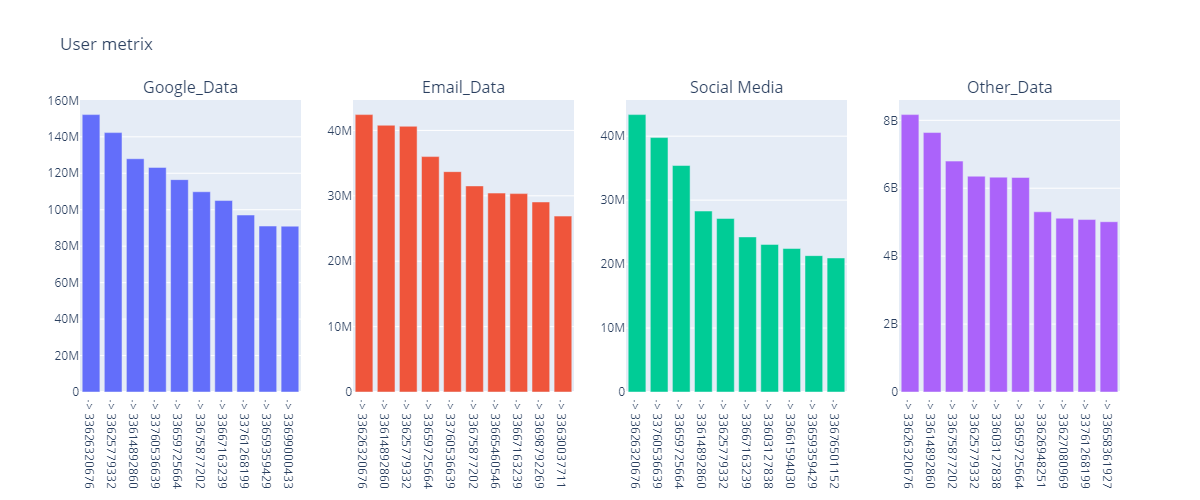

In [29]:
Gaming_Data = agg_user_traffic.nlargest(10, "Gaming Data Volume (Bytes)")['Gaming Data Volume (Bytes)']
Youtube_Data = agg_user_traffic.nlargest(10, "Youtube Data Volume (Bytes)")['Youtube Data Volume (Bytes)']
Netflix_Data = agg_user_traffic.nlargest(10, "Netflix Data Volume (Bytes)")['Netflix Data Volume (Bytes)']
Google_Data = agg_user_traffic.nlargest(10, "Google Data Volume (Bytes)")['Google Data Volume (Bytes)']
Email_Data = agg_user_traffic.nlargest(10, "Email Data Volume (Bytes)")['Email Data Volume (Bytes)']
Social_Media = agg_user_traffic.nlargest(10, "Social Media Data Volume (Bytes)")['Social Media Data Volume (Bytes)']
Other_Data = agg_user_traffic.nlargest(10, "Other Data Volume (Bytes)")['Other Data Volume (Bytes)']


mult_hist([Gaming_Data, Youtube_Data, Netflix_Data], 1,
          3, "User metrix", ["Gaming_Data", "Youtube_Data", "Netflix_Data"])
mult_hist([Google_Data, Email_Data, Social_Media, Other_Data], 1,
          4, "User metrix", [ "Google_Data", "Email_Data", "Social Media", "Other_Data"])

5. Plot the top 3 most used applications using appropriate charts.

In [30]:
top_3_apps = agg_user_traffic.sum()
top_3_apps

Gaming Data Volume (Bytes)          6.321321e+13
Youtube Data Volume (Bytes)         3.325813e+12
Netflix Data Volume (Bytes)         3.323940e+12
Google Data Volume (Bytes)          1.146890e+12
Email Data Volume (Bytes)           3.318305e+11
Social Media Data Volume (Bytes)    2.684706e+11
Other Data Volume (Bytes)           6.305373e+13
dtype: float64

In [31]:
hist(top_3_apps.nlargest(3))

6. Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics.

- What is the optimized value of k(use elbow method for this)?
    -Interpret your findings.
    
**Distortion-** is the average of the euclidean squared distance from the centroid of the respective clusters.

**Inertia-** is the sum of squared distances of samples to their closest cluster centre.

In [32]:
df= clean_df

In [33]:
def choose_kmeans(df: pd.DataFrame, num: int):
    distortions = []
    inertias = []
    K = range(1, num)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
        distortions.append(sum(
            np.min(cdist(df, kmeans.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])
        inertias.append(kmeans.inertia_)
    return (distortions, inertias)

In [34]:
distortions, inertias = choose_kmeans(normalized_engagements, 15)

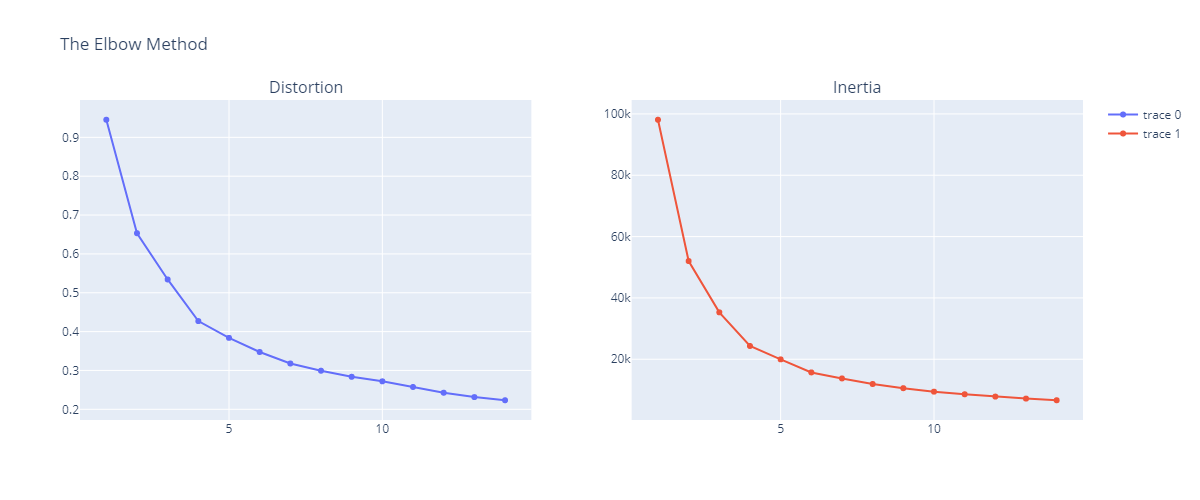

In [35]:
fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Distortion", "Inertia")
)
fig.add_trace(go.Scatter(x=np.array(range(1, 15)), y=distortions), row=1, col=1)
fig.add_trace(go.Scatter(x=np.array(range(1, 15)), y=inertias), row=1, col=2)
fig.update_layout(title_text="The Elbow Method")
# fig.show(config=config)
Image(pio.to_image(fig, format='png', width=1200))

In [36]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(normalized_engagements)
user_engagements["cluster"]= kmeans.labels_
user_engagements

cluster  user_sessions  time_duration  \
MSISDN/Number                                            
33601001722            0            1.0    116720140.0   
33601001754            2            1.0    181230963.0   
33601002511            2            1.0    134969374.0   
33601007832            3            1.0     49878024.0   
33601008617            1            2.0     37104453.0   
...                  ...            ...            ...   
33789967113            2            1.0    160461578.0   
33789980299            1            2.0    210390146.0   
33789996170            0            1.0      8810688.0   
33789997247            2            1.0    140988659.0   
337000037000919        2            1.0    245108160.5   

                 Total Data Volume (Bytes)  
MSISDN/Number                               
33601001722                   8.786906e+08  
33601001754                   1.568596e+08  
33601002511                   5.959665e+08  
33601007832                   4.223207e+08  
33601008617                   1.457411e+09  
...                                    ...  
33789967113                   2.081231e+08  
33789980299                   1.094693e+09  
33789996170                   7.146416e+08  
33789997247                   4.803073e+08  
337000037000919               5.962878e+08  

[105716 rows x 4 columns]

In [37]:
user_engagements.shape

(105716, 4)

In [42]:
user_engagements.to_csv('../data/TellCo_user_engagements.csv')

In [40]:
import pickle

In [41]:
with open("../models/TellCo_user_engagement.pkl", "wb") as f:
    pickle.dump(kmeans, f)